In [1]:
import numpy as np
from scipy.stats import norm
import numpy as np
import astropy
from astropy.io import fits
from astropy import units as u
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
import healpy as hp
import pandas as pd
import math
import scipy
import statistics as st
from scipy import stats
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from IPython.display import Image

%matplotlib inline

NSIDE=2048
Npix=12*NSIDE**2

pi=math.pi

import warnings
warnings.filterwarnings('ignore')

---

### Read in MMF3

In [2]:
amfFull = pd.read_csv('amfFull.tsv',sep='|')

c = SkyCoord(amfFull['RAJ2000'],amfFull['DEJ2000'],frame='icrs',unit='deg')

amfFull['GLAT'] = c.galactic.b.degree
amfFull['GLON'] = c.galactic.l.degree

amfFull['GLAT'] = np.around(amfFull['GLAT'].values,1)
amfFull['GLON'] = np.around(amfFull['GLON'].values,1)
print(amfFull.iloc[0,11]) # glat
print(amfFull.iloc[0,12]) # glon
amfFull

-40.9
136.7


,ID,AMF9,RAJ2000,DEJ2000,z,Lk,Lambda200,r200,rc,c,str-rh,GLAT,GLON
0,4,J013539.1+204447,23.9128,20.7465,0.0601,176.9125,219.3663,1.946,0.925,2.104,73.0001,-40.9,136.7
1,5,J172231.8+320823,260.6324,32.1398,0.2252,222.1219,200.7117,1.784,0.625,2.856,35.0001,31.8,55.6
2,6,J131131.1-012008,197.8796,-1.3356,0.2042,171.6872,192.0829,1.773,0.227,7.792,9.0001,61.1,313.4
3,7,J164035.6+464130,250.1485,46.6917,0.2248,225.9874,182.3373,1.725,0.495,3.483,36.0001,41.4,72.6
4,8,J230521.6+210216,346.3402,21.0378,0.1453,121.0124,182.2769,1.775,0.440,4.034,72.0001,-35.4,92.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46474,54273,J212414.7-053519,321.0614,-5.5885,0.4036,7.3319,20.0008,0.734,0.260,2.823,85.1216,-36.3,46.9
46475,54274,J104720.5-025526,161.7603,-2.9238,0.2064,11.9584,20.0006,0.790,0.090,8.781,9.1111,47.5,253.1
46476,54275,J213855.7+153523,324.7319,15.5898,0.1964,8.6750,20.0005,0.793,0.180,4.404,73.0886,-26.7,69.5
46477,54276,J085114.6+015313,132.8109,1.8870,0.2697,12.2539,20.0002,0.772,0.260,2.971,12.1012,27.3,225.8


### Check against union mask

In [29]:
mask = hp.read_map('HFI_PCCS_SZ-selfunc-union-survey_2.02.fits')

# Get the nside and number of pixels in your map
nside = hp.get_nside(mask)
npix = hp.nside2npix(nside)
maskedPixels, = np.where(mask == 0)

# Use pix2ang to get the (l, b) coordinates for each pixel
glons, glats = hp.pix2ang(nside, maskedPixels, lonlat=True)
maskedArray = pd.DataFrame({'glon': np.around(glons,1), 'glat': np.around(glats,1)})
maskedArray = maskedArray[((maskedArray.glat > 10)|((maskedArray.glat<-10) & ((maskedArray.glon<210)))) | ((maskedArray.glat>0) & ((maskedArray.glon<240)&(maskedArray.glon>180)))].reset_index()

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


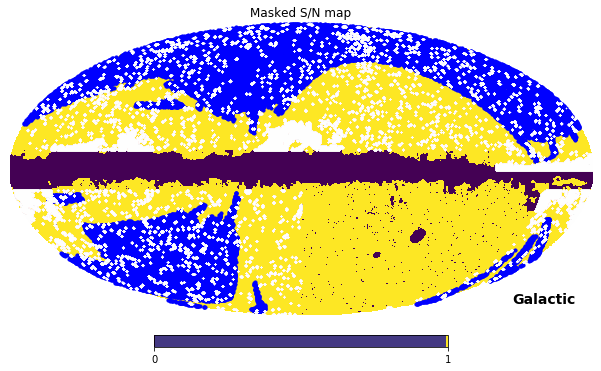

In [30]:
hp.mollview(mask,norm='hist',coord=['G'],title='Masked S/N map')
hp.visufunc.projscatter(amfFull['GLON'],amfFull['GLAT'],c='b',lonlat=True,s=10)
hp.visufunc.projscatter(maskedArray.glon,maskedArray.glat,c='w',lonlat=True,s=0.1)

In [31]:
# Get the nside and number of pixels in your map
nside = hp.get_nside(mask)
npix = hp.nside2npix(nside)
maskedPixels, = np.where(mask == 0)

# Use pix2ang to get the (l, b) coordinates for each pixel
glons, glats = hp.pix2ang(nside, maskedPixels, lonlat=True)
maskedArray = pd.DataFrame({'glon': np.around(glons,1), 'glat': np.around(glats,1)})
maskedArray = maskedArray[(maskedArray.glat > 15)|((maskedArray.glat<-15) & ((maskedArray.glon<210)))].reset_index()

In [ ]:
unionLons = []
unionLats = []

for i in range(amfFull.shape[0]):
    matchFlag=False
    for j in range(11): # Within 1 degree
        print(i,amfFull.iloc[i][12],amfFull.iloc[i][11])
        if not maskedArray.loc[np.logical_and(maskedArray.glon == amfFull.iloc[i][12]+j/10, maskedArray.glat == amfFull.iloc[i][11]+j/10)].empty:
            print("MATCH")
            matchFlag=True
            unionLons.append(amfFull.iloc[i][12])
            unionLats.append(amfFull.iloc[i][11])
            break
    if not matchFlag:
        for j in range(11): # Within 1 degree
            print(i,amfFull.iloc[i][12],amfFull.iloc[i][11])
            if not maskedArray.loc[np.logical_and(maskedArray.glon == amfFull.iloc[i][12]-j/10, maskedArray.glat == amfFull.iloc[i][11]-j/10)].empty:
                print("MATCH")
                matchFlag=True
                unionLons.append(amfFull.iloc[i][12])
                unionLats.append(amfFull.iloc[i][11])
                break
masked = pd.DataFrame({'glon': unionLons, 'glat': unionLats})

0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
0 136.7 -40.9
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
1 55.6 31.8
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
2 313.4 61.1
3 72.6 41.4
3 72.6 41.4
3 72.6 41.4
3 72.6 41.4
3 72.6 41.4
MATCH
4 92.2 -35.4
MATCH
5 116.5 -44.5
5 116.5 -44.5
5 116.5 -44.5
5 116.5 -44.5
5

31 231.6 60.0
31 231.6 60.0
31 231.6 60.0
31 231.6 60.0
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
32 204.2 15.4
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
33 229.7 78.0
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
34 89.8 -39.5
35 155.2 -14.6
35 15

62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
62 123.7 67.3
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
63 130.3 -62.6
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
64 140.5 -40.9
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 90.6 -45.2
65 9

90 218.8 35.5
90 218.8 35.5
90 218.8 35.5
90 218.8 35.5
90 218.8 35.5
90 218.8 35.5
90 218.8 35.5
90 218.8 35.5
91 58.7 -46.7
MATCH
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
92 84.7 -25.0
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
93 201.5 -49.3
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 126.6 -37.7
94 12

119 84.2 -25.1
119 84.2 -25.1
119 84.2 -25.1
119 84.2 -25.1
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
120 53.5 -46.9
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
121 123.0 -35.5
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
122 108.5 -30.7
12

146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
146 71.6 -38.0
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
147 165.6 43.9
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
148 68.3 81.8
149 225.9 41.8
149 225.9 41.8
149 225.9 41.8
14

174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
174 46.7 66.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
175 85.4 -80.6
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
176 276.7 62.2
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 180.7 -74.5
177 

200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
200 305.3 82.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
201 183.3 35.0
MATCH
202 182.0 -56.9
202 182.0 -56.9
202 182.0 -56.9
202 182.0 -56.9
MATCH
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
203 118.1 -43.7
204 228.5 35.0
204 228.5 35.0
204 228.5 35.0
204 228.5 35.0
204 228.5 35.0
204 228.5 35.0
204 228.5 35.0
20

229 204.1 16.5
229 204.1 16.5
229 204.1 16.5
229 204.1 16.5
229 204.1 16.5
229 204.1 16.5
229 204.1 16.5
230 228.5 57.9
MATCH
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
231 114.5 -45.3
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
232 11.6 47.8
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 153.5 83.0
233 

258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
258 115.7 -27.6
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
259 218.3 71.3
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
260 181.5 -44.8
261 71.5 59.5
261 71.5 59.5
261 71.5 59.5
261 71.5 59.5
261 71

285 204.1 16.5
285 204.1 16.5
285 204.1 16.5
285 204.1 16.5
285 204.1 16.5
285 204.1 16.5
285 204.1 16.5
285 204.1 16.5
285 204.1 16.5
285 204.1 16.5
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
286 89.5 -38.0
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
287 77.1 -65.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.5
288 127.9 -29.

313 81.8 70.2
313 81.8 70.2
313 81.8 70.2
313 81.8 70.2
313 81.8 70.2
313 81.8 70.2
313 81.8 70.2
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
314 182.6 55.9
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
315 94.5 -69.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
316 156.1 -58.7
31

342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
342 81.1 -47.0
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
343 151.2 48.3
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
344 170.8 -65.8
345

368 226.5 78.3
368 226.5 78.3
368 226.5 78.3
368 226.5 78.3
368 226.5 78.3
368 226.5 78.3
368 226.5 78.3
368 226.5 78.3
368 226.5 78.3
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
369 172.0 69.6
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
370 180.4 76.7
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 26.8
371 223.5 

395 166.9 -46.2
395 166.9 -46.2
395 166.9 -46.2
395 166.9 -46.2
MATCH
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
396 170.4 -44.8
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
397 49.3 65.1
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.5
398 127.5 -30.

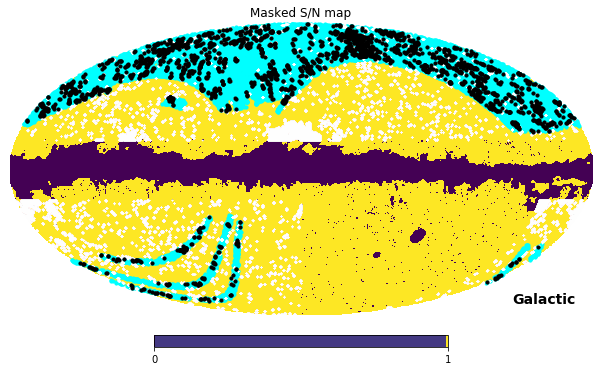

In [35]:
hp.mollview(mask,norm='hist',coord=['G'],title='Masked S/N map')
hp.visufunc.projscatter(amfFull['GLON'],amfFull['GLAT'],c='cyan',lonlat=True,s=10)
hp.visufunc.projscatter(maskedArray.glon,maskedArray.glat,c='w',lonlat=True,s=0.1)
hp.visufunc.projscatter(unionLons, unionLats,c='k',lonlat=True,s=10)

In [37]:
len(unionLons)

2470

---